<a href="https://colab.research.google.com/github/spyrosviz/Injury_Prediction_MidLong_Distance_Runners/blob/main/ML%20models/Models_Runners_Injury_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [152]:
# Import Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier, BaggingClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
import itertools
from collections import Counter
!pip install imbalanced-learn
from imblearn.over_sampling import SMOTE, RandomOverSampler, ADASYN
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
import tensorflow as tf

**Use the following split if you want to hold out a specified number of athletes for train and test set. The last 10 athletes instances were kept for test set.**

In [2]:
'''Import data and hold out a specified test set'''

# Import data from excel, select the first 63 athletes events for train set and the last 10 athletes for test set
df = pd.read_excel(r'/content/drive/MyDrive/Runners_Injury_MLproject/Daily_Injury_Clean.xlsx',index_col = [0])
df_train = df[df['Athlete ID'] <= 63]
df_train.drop(['Date','Athlete ID'],axis=1,inplace=True)
df_test = df[df['Athlete ID'] > 63]
df_test.drop(['Date','Athlete ID'],axis=1,inplace=True)

# Check if df_train has any equal instances with df_test. We expect to return an empty dataframe if they do not share common instances
print(df_train[df_test.eq(df_train).all(axis=1)==True])

''' Set y '''
y_train = df_train['injury'].values
y_test = df_test['injury'].values

''' Set all columns for X except injury which is the target'''
X_train = df_train.drop(['injury'],axis=1).values
X_test = df_test.drop(['injury'],axis=1).values
column_names = df_train.drop(['injury'],axis=1).columns

#selected_features = ['Total Weekly Distance','Acute Load','Strain','Monotony','injury']

''' Set X after dropping selected features '''
#X_test = df_test.drop(selected_features,axis=1).values
#X_train = df_train.drop(selected_features,axis=1).values
#column_names = df_train.drop(selected_features,axis=1).columns

''' Set selected features as X '''
#X_train = df_train.loc[:,selected_features].values
#X_test = df_test.loc[:,selected_features].values
#column_names = df_train.loc[:,selected_features].columns

# Print dataframes shapes and respective number of healthy and injury events
print(column_names)
print(Counter(df_train['injury'].values))
print(Counter(df_test['injury'].values))

Empty DataFrame
Columns: [nr. sessions, total km, km Z3-4, km Z5-T1-T2, km sprinting, strength training, hours alternative, perceived exertion, perceived trainingSuccess, perceived recovery, nr. sessions.1, total km.1, km Z3-4.1, km Z5-T1-T2.1, km sprinting.1, strength training.1, hours alternative.1, perceived exertion.1, perceived trainingSuccess.1, perceived recovery.1, nr. sessions.2, total km.2, km Z3-4.2, km Z5-T1-T2.2, km sprinting.2, strength training.2, hours alternative.2, perceived exertion.2, perceived trainingSuccess.2, perceived recovery.2, nr. sessions.3, total km.3, km Z3-4.3, km Z5-T1-T2.3, km sprinting.3, strength training.3, hours alternative.3, perceived exertion.3, perceived trainingSuccess.3, perceived recovery.3, nr. sessions.4, total km.4, km Z3-4.4, km Z5-T1-T2.4, km sprinting.4, strength training.4, hours alternative.4, perceived exertion.4, perceived trainingSuccess.4, perceived recovery.4, nr. sessions.5, total km.5, km Z3-4.5, km Z5-T1-T2.5, km sprinting.5,

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


**Use the following dataset split if you want to hold out 2000 random healthy instancies and 50 random injury instancies**

In [ ]:
'''Import data and holdout a random test set'''

# Import data from excel and drop Date and Athlete ID column
df = pd.read_excel(r'/content/drive/MyDrive/Runners_Injury_MLproject/run_injur_with_acuteloads.xlsx',index_col = [0])

# Hold out a test set with 100 random injury events and 100 random healthy events 
df_copy = df.copy()
df_copy.drop(['Date','Athlete ID'],axis=1,inplace=True)
df_inj = df_copy[df_copy['injury']==1].sample(50,random_state=42)
df_uninj = df_copy[df_copy['injury']==0].sample(2000,random_state=42)
df_test = pd.concat([df_inj,df_uninj],ignore_index=True)

# Drop the test set from the original dataframe
df_train = pd.concat([df_copy,df_test],ignore_index=True).drop_duplicates(keep=False)

# Set X and y
y_train = df_train['injury'].values
y_test = df_test['injury'].values
selected_features = ['Total Weekly Distance','Acute Load','Strain','Monotony','injury']
X_test = df_test.drop(selected_features,axis=1).values
X_train = df_train.drop(selected_features,axis=1).values
#X_train = df_train.loc[:,selected_features].values
#X_test = df_test.loc[:,selected_features].values

# Check if df_train has any equal instances with df_test. We expect to return an empty dataframe if they do not share common instances
# Print dataframe shapes and respective number of healthy and injury events
print(df_train[df_test.eq(df_train).all(axis=1)==True])
#print(df_train.drop(['Acute Load','Total Weekly Distance','Monotony','Strain','injury'],axis=1).columns)
print(df_train.shape)
print(Counter(df_train['injury'].values))
print(df_test.shape)
print(Counter(df_test['injury'].values))

Empty DataFrame
Columns: [nr. sessions, total km, km Z3-4, km Z5-T1-T2, km sprinting, strength training, hours alternative, perceived exertion, perceived trainingSuccess, perceived recovery, nr. sessions.1, total km.1, km Z3-4.1, km Z5-T1-T2.1, km sprinting.1, strength training.1, hours alternative.1, perceived exertion.1, perceived trainingSuccess.1, perceived recovery.1, nr. sessions.2, total km.2, km Z3-4.2, km Z5-T1-T2.2, km sprinting.2, strength training.2, hours alternative.2, perceived exertion.2, perceived trainingSuccess.2, perceived recovery.2, nr. sessions.3, total km.3, km Z3-4.3, km Z5-T1-T2.3, km sprinting.3, strength training.3, hours alternative.3, perceived exertion.3, perceived trainingSuccess.3, perceived recovery.3, nr. sessions.4, total km.4, km Z3-4.4, km Z5-T1-T2.4, km sprinting.4, strength training.4, hours alternative.4, perceived exertion.4, perceived trainingSuccess.4, perceived recovery.4, nr. sessions.5, total km.5, km Z3-4.5, km Z5-T1-T2.5, km sprinting.5,

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [3]:
class_imbalance = len(df_train[df_train['injury']==1].values)/len(df_train[df_train['injury']==0].values)
print(f'Class imbalance is {class_imbalance}')

Class imbalance is 0.01360075531399117


**Write a function to pretiffy confusion matrix results.
The function was found from Daniel Bourke's Tensorflow course**

In [4]:
def plot_confusion_matrix(y_true,y_pred,class_names,figsize=(10,10),text_size=15):

    # create the confusion matrix
    cm = confusion_matrix(y_true,y_pred)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:,np.newaxis] # normalize confusion matrix
    n_classes = cm.shape[0]

    fig, ax = plt.subplots(figsize=figsize)
    matrix_plot = ax.matshow(cm, cmap=plt.cm.Blues)
    fig.colorbar(matrix_plot)

    # Set labels to be classes
    if class_names:
        labels = class_names
    else:
        labels = np.arange(cm.shape[0])

    # Label the axes
    ax.set(title='Confusion Matrix',
           xlabel = 'Predicted Label',
           ylabel = 'True Label',
           xticks = np.arange(n_classes),
           yticks = np.arange(n_classes),
           xticklabels = labels,
           yticklabels = labels)

    # Set x axis labels to bottom
    ax.xaxis.set_label_position('bottom')
    ax.xaxis.tick_bottom()

    # Adjust label size
    ax.yaxis.label.set_size(text_size)
    ax.xaxis.label.set_size(text_size)
    ax.title.set_size(text_size)

    # Set threshold for different colors
    threshold = (cm.max() + cm.min()) / 2

    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,f'{cm[i,j]} ({cm_norm[i,j] * 100:.1f}%)',
                 horizontalalignment='center',
                 color='white' if cm[i,j] > threshold else 'black',
                 size = text_size)

Because there is very high class imbalance in the injury variable that we want to predict, we will try the following techniques to overcome this problem and see what works best:
* **Weighted XGBoost**
* **XGBoost with Smote algorithm for Resampling**
* **XGBoost model with Random Resampling**
* **Bagging XGBoost model with Random Resampling**
* **Neural Networks model with Random Undersampling**

In [5]:
# Set X and y with different resampling methods

'''SMOTE algorithm for oversampling 15% ratio and random undersampling 1-1 ratio'''
# Oversample the minority class to have number of instances equal with the 15% of the majority class
smote = SMOTE(sampling_strategy=0.15,random_state=1)
X_sm,y_sm = smote.fit_resample(X_train,y_train)

# Downsample the majority class to have number of instances equal with the minority class
undersamp = RandomUnderSampler(sampling_strategy=1,random_state=1)
X_smus,y_smus = undersamp.fit_resample(X_sm,y_sm)

'''Random oversampling 10% ratio and random undersampling 1-1 ratio'''
# Random over sampler for minority class to 1:10 class ratio
ros = RandomOverSampler(sampling_strategy=0.1,random_state=21)
X_ros,y_ros = ros.fit_resample(X_train,y_train)

# Undersample the majority class to have number of instances equal with the minority class
undersamp = RandomUnderSampler(sampling_strategy=1,random_state=21)
X_rosus,y_rosus = undersamp.fit_resample(X_ros,y_ros)

'''Random undersampling 1-1 ratio'''
# Random under sampler for majority class to 1:1 class ratio
rus = RandomUnderSampler(sampling_strategy=1,random_state=21)
X_rus,y_rus = rus.fit_resample(X_train,y_train)

'''Tomek Links Undersampling'''
tmkl = TomekLinks()
X_tmk, y_tmk = tmkl.fit_resample(X_train,y_train)

'''ADASYN for oversampling 15% ratio and random undersampler 1-1 ratio'''
# ADASYN oversample minority class to 15% of the majority class
adasyn = ADASYN(sampling_strategy=0.15,random_state=21)
X_ada, y_ada = adasyn.fit_resample(X_train,y_train)

# Random undersample the majority class to have equal instances with minority class
adarus = RandomUnderSampler(sampling_strategy=1,random_state=21)
X_adarus,y_adarus = adarus.fit_resample(X_ada,y_ada)

In [6]:
# Stratify crossvalidation

cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=21)

## 1) Weighted XGBoost Model

In [61]:
'''Weighted XGBoost'''

# We will use scale_pos_weight argument in xgboost algorithm which increases the error for wrong positive class prediction.
# From xgboost documentation it's suggested that the optimal value for scale_pos_weight argument is usually around the
# sum(negative instances)/sum(positive instances). We will use randomizedsearchcv to find optimal value

xgb_weight = XGBClassifier()
param_grid_weight = {"gamma":[0.01,0.1,1,10,50,100,1000],'reg_lambda':[1,5,10,20],
                     'learning_rate':np.arange(0.01,1,0.01),'eta':np.arange(0.1,1,0.1),'scale_pos_weight':[60,70,80,90,100]}
gscv_weight = RandomizedSearchCV(xgb_weight,param_distributions=param_grid_weight,cv=cv,scoring='roc_auc')
gscv_weight.fit(X_train,y_train)
print("Best param is {}".format(gscv_weight.best_params_))
print("Best score is {}".format(gscv_weight.best_score_))

optimal_gamma = gscv_weight.best_params_['gamma']
optimal_reg_lambda = gscv_weight.best_params_['reg_lambda']
optim_lr = gscv_weight.best_params_['learning_rate']
optimal_eta = gscv_weight.best_params_['eta']
optimal_scale_pos_weight = gscv_weight.best_params_['scale_pos_weight']

Best param is {'scale_pos_weight': 90, 'reg_lambda': 20, 'learning_rate': 0.23, 'gamma': 0.01, 'eta': 0.6}
Best score is 0.5895046129151751


In [62]:
tuned_xgb_weight = XGBClassifier(gamma=optimal_gamma,learning_rate=optim_lr,eta=optimal_eta,reg_lambda=optimal_reg_lambda,scale_pos_weight=optimal_scale_pos_weight,
                                 colsample_bytree=0.5,min_child_weight=90,objective='binary:logistic',subsample=0.5)
tuned_xgb_weight.fit(X_train,y_train,early_stopping_rounds=10,eval_metric='auc',eval_set=[(X_test,y_test)])

[0]	validation_0-auc:0.553711
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.602144
[2]	validation_0-auc:0.637224
[3]	validation_0-auc:0.634626
[4]	validation_0-auc:0.617141
[5]	validation_0-auc:0.615595
[6]	validation_0-auc:0.611754
[7]	validation_0-auc:0.608607
[8]	validation_0-auc:0.609275
[9]	validation_0-auc:0.621176
[10]	validation_0-auc:0.621847
[11]	validation_0-auc:0.62831
[12]	validation_0-auc:0.640124
[13]	validation_0-auc:0.638153
[14]	validation_0-auc:0.637291
[15]	validation_0-auc:0.629035
[16]	validation_0-auc:0.627248
[17]	validation_0-auc:0.631844
[18]	validation_0-auc:0.633373
[19]	validation_0-auc:0.638343
[20]	validation_0-auc:0.650511
[21]	validation_0-auc:0.652669
[22]	validation_0-auc:0.65689
[23]	validation_0-auc:0.655568
[24]	validation_0-auc:0.660691
[25]	validation_0-auc:0.661593
[26]	validation_0-auc:0.660438
[27]	validation_0-auc:0.66168
[28]	validation_0-auc:0.664706
[29]	validation_0-auc:0.673297
[30]	validation_0-a

XGBClassifier(colsample_bytree=0.5, eta=0.6, gamma=0.01, learning_rate=0.23,
              min_child_weight=90, reg_lambda=20, scale_pos_weight=90,
              subsample=0.5)

Area under curve score is 0.702438209752839
Sensitivity is 76.0% and specificity is 60.120240480961925%


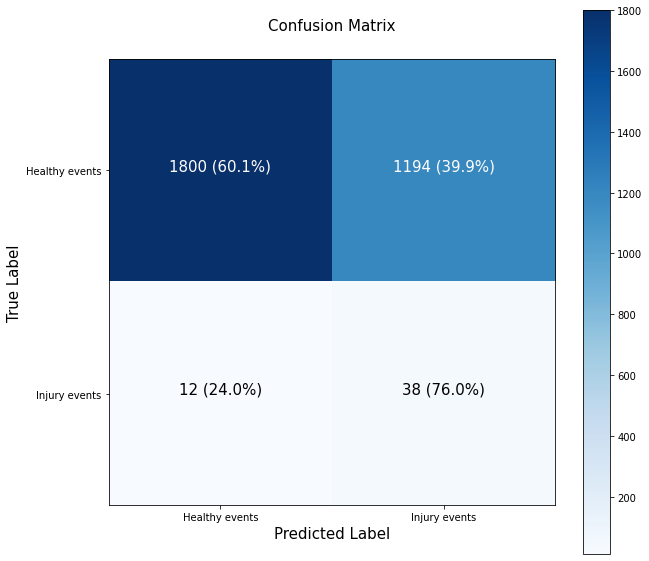

In [63]:
# Evaluate model's performance on the test set, with AUC, confusion matrix, sensitivity and specificity

y_pred = tuned_xgb_weight.predict(X_test)

print(f'Area under curve score is {roc_auc_score(y_test,tuned_xgb_weight.predict_proba(X_test)[:,1])}')

# Compute true positives, true neagatives, false negatives and false positives
tp = confusion_matrix(y_test,y_pred)[1,1]
tn = confusion_matrix(y_test,y_pred)[0,0]
fn = confusion_matrix(y_test,y_pred)[1,0]
fp = confusion_matrix(y_test,y_pred)[0,1]

# Compute sensitivity and specificity
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
print(f'Sensitivity is {sensitivity*100}% and specificity is {specificity*100}%')

plot_confusion_matrix(y_true=y_test, y_pred=y_pred, class_names=['Healthy events','Injury events'])

##2) XGBoost Model with SMOTE combined with Random Undersampling

In [32]:
'''XGBoost Classifier and SMOTE (Synthetic Minority Oversampling Technique) combined with Random Undersampling'''

# Check the number of instances for each class before and after resampling
print(Counter(y_train))
print(Counter(y_smus))

xgb_sm = XGBClassifier()
param_grid_sm = {"gamma":[0.01,0.1,1,10,50,100,1000],'learning_rate':np.arange(0.01,1,0.01),'eta':np.arange(0.1,1,0.1),'reg_lambda':[1,5,10,20]}
gscv_sm = RandomizedSearchCV(xgb_sm,param_distributions=param_grid_sm,cv=5,scoring='roc_auc')
gscv_sm.fit(X_smus,y_smus)
print("Best param is {}".format(gscv_sm.best_params_))
print("Best score is {}".format(gscv_sm.best_score_))

optimal_gamma = gscv_sm.best_params_['gamma']
optim_lr = gscv_sm.best_params_['learning_rate']
optimal_eta = gscv_sm.best_params_['eta']
optimal_lambda = gscv_sm.best_params_['reg_lambda']

Counter({0: 39189, 1: 533})
Counter({0: 5878, 1: 5878})
Best param is {'reg_lambda': 20, 'learning_rate': 0.7100000000000001, 'gamma': 1, 'eta': 0.4}
Best score is 0.963961113769578


In [58]:
tuned_xgb_sm = XGBClassifier(gamma=optimal_gamma,learning_rate=optim_lr,eta=optimal_eta,reg_lambda=optimal_lambda,subsample=0.4,
                             colsample_bytree=0.6,min_child_weight=90,objective='binary:logistic')
tuned_xgb_sm.fit(X_smus,y_smus,early_stopping_rounds=10,eval_metric='auc',eval_set=[(X_test,y_test)])

[0]	validation_0-auc:0.611192
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.660758
[2]	validation_0-auc:0.661787
[3]	validation_0-auc:0.649977
[4]	validation_0-auc:0.640434
[5]	validation_0-auc:0.656112
[6]	validation_0-auc:0.649071
[7]	validation_0-auc:0.651012
[8]	validation_0-auc:0.653036
[9]	validation_0-auc:0.648056
[10]	validation_0-auc:0.662241
[11]	validation_0-auc:0.650558
[12]	validation_0-auc:0.652749
[13]	validation_0-auc:0.641199
[14]	validation_0-auc:0.614653
[15]	validation_0-auc:0.625721
[16]	validation_0-auc:0.637836
[17]	validation_0-auc:0.640922
[18]	validation_0-auc:0.642184
[19]	validation_0-auc:0.638063
[20]	validation_0-auc:0.630595
Stopping. Best iteration:
[10]	validation_0-auc:0.662241



XGBClassifier(colsample_bytree=0.6, eta=0.4, gamma=1,
              learning_rate=0.7100000000000001, min_child_weight=90,
              reg_lambda=20, subsample=0.4)

Area under curve score is 0.6622411489645958
Sensitivity is 34.0% and specificity is 81.83032732130928%


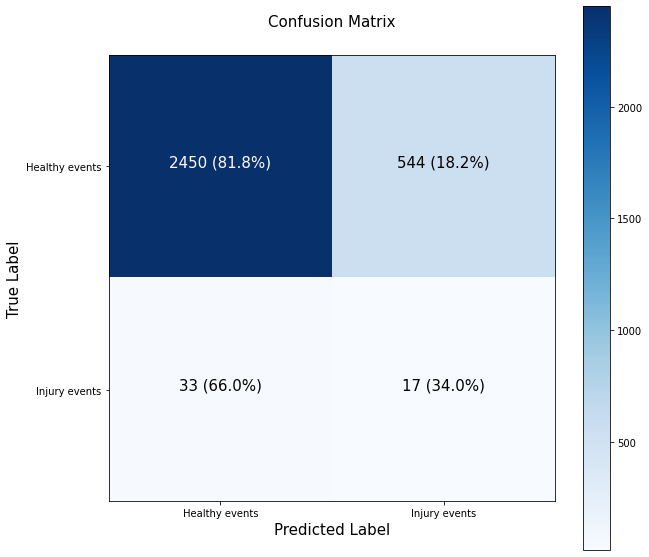

In [60]:
# Evaluate model's performance on the test set, with AUC, confusion matrix, sensitivity and specificity

y_pred = tuned_xgb_sm.predict(X_test)

print(f'Area under curve score is {roc_auc_score(y_test,tuned_xgb_sm.predict_proba(X_test)[:,1])}')

# Compute true positives, true neagatives, false negatives and false positives
tp = confusion_matrix(y_test,y_pred)[1,1]
tn = confusion_matrix(y_test,y_pred)[0,0]
fn = confusion_matrix(y_test,y_pred)[1,0]
fp = confusion_matrix(y_test,y_pred)[0,1]

# Compute sensitivity and specificity
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
print(f'Sensitivity is {sensitivity*100}% and specificity is {specificity*100}%')

plot_confusion_matrix(y_true=y_test, y_pred=y_pred, class_names=['Healthy events','Injury events'])

## 3) XGBoost Model with Random Resampling

In [64]:
'''XGBoost Classifier and Random Undersampling'''

# Check the number of instances for each class before and after resampling
print(Counter(y_train))
print(Counter(y_rosus))

xgb_rus = XGBClassifier()
param_grid_rus = {"gamma":[0.01,0.1,1,10,50,100,1000],'reg_lambda':[1,5,10,20],'learning_rate':np.arange(0.01,1,0.01),'eta':np.arange(0.1,1,0.1)}
gscv_rus = RandomizedSearchCV(xgb_rus,param_distributions=param_grid_rus,cv=5,scoring='roc_auc')
gscv_rus.fit(X_rosus,y_rosus)
print("Best param is {}".format(gscv_rus.best_params_))
print("Best score is {}".format(gscv_rus.best_score_))

optimal_gamma = gscv_rus.best_params_['gamma']
optimal_reg_lambda = gscv_rus.best_params_['reg_lambda']
optim_lr = gscv_rus.best_params_['learning_rate']
optimal_eta = gscv_rus.best_params_['eta']

Counter({0: 39189, 1: 533})
Counter({0: 3918, 1: 3918})
Best param is {'reg_lambda': 5, 'learning_rate': 0.6900000000000001, 'gamma': 1, 'eta': 0.2}
Best score is 0.9601002712690754


In [89]:
tuned_xgb_rus = XGBClassifier(gamma=optimal_gamma,reg_lambda=optimal_reg_lambda,learning_rate=optim_lr,eta=optimal_eta,
                              colsample_bytree=0.7,min_child_weight=9,objective='binary:logistic',subsample=0.8)
tuned_xgb_rus.fit(X_rosus,y_rosus,early_stopping_rounds=10,eval_metric='auc',eval_set=[(X_test,y_test)])

[0]	validation_0-auc:0.579669
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.588874
[2]	validation_0-auc:0.546109
[3]	validation_0-auc:0.555107
[4]	validation_0-auc:0.570431
[5]	validation_0-auc:0.585691
[6]	validation_0-auc:0.631974
[7]	validation_0-auc:0.642722
[8]	validation_0-auc:0.659005
[9]	validation_0-auc:0.658353
[10]	validation_0-auc:0.657468
[11]	validation_0-auc:0.664315
[12]	validation_0-auc:0.631533
[13]	validation_0-auc:0.623631
[14]	validation_0-auc:0.601069
[15]	validation_0-auc:0.592779
[16]	validation_0-auc:0.589365
[17]	validation_0-auc:0.59849
[18]	validation_0-auc:0.598851
[19]	validation_0-auc:0.590935
[20]	validation_0-auc:0.583714
[21]	validation_0-auc:0.577822
Stopping. Best iteration:
[11]	validation_0-auc:0.664315



XGBClassifier(colsample_bytree=0.7, eta=0.2, gamma=1,
              learning_rate=0.6900000000000001, min_child_weight=9,
              reg_lambda=5, subsample=0.8)

Area under curve score is 0.664315297261189
Sensitivity is 60.0% and specificity is 60.52104208416834%


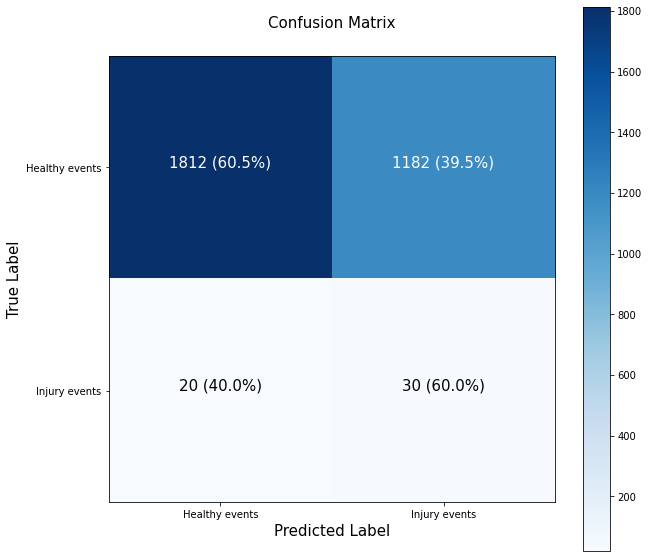

In [90]:
# Evaluate model's performance on the test set, with AUC, confusion matrix, sensitivity and specificity

y_pred = tuned_xgb_rus.predict(X_test)

print(f'Area under curve score is {roc_auc_score(y_test,tuned_xgb_rus.predict_proba(X_test)[:,1])}')

# Compute true positives, true neagatives, false negatives and false positives
tp = confusion_matrix(y_test,y_pred)[1,1]
tn = confusion_matrix(y_test,y_pred)[0,0]
fn = confusion_matrix(y_test,y_pred)[1,0]
fp = confusion_matrix(y_test,y_pred)[0,1]

# Compute sensitivity and specificity
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
print(f'Sensitivity is {sensitivity*100}% and specificity is {specificity*100}%')

plot_confusion_matrix(y_true=y_test, y_pred=y_pred, class_names=['Healthy events','Injury events'])

## 4) Bagging Model with XGBoost base estimators and Random Resampling

In [141]:
'''Bagging Classifier with XGBoost base estimators and Random Undersampling with combined Oversampling'''

# Check the number of instances for each class before and after resampling
print(Counter(y_train))
print(Counter(y_rosus))

base_est = XGBClassifier(gamma=optimal_gamma,reg_lambda=optimal_reg_lambda,learning_rate=optim_lr,eta=optimal_eta,
                              colsample_bytree=0.6,min_child_weight=90,objective='binary:logistic',subsample=0.8,n_estimators=11)

# XGBoost base classifier
#base_est = XGBClassifier(n_estimators=512,learning_rate=0.01,max_depth=3)

# Bagging XGBoost Classifier
bagg = BaggingClassifier(base_estimator=base_est,n_estimators=9,max_samples=2048,random_state=21)

# Platt's Scaling to get probabilities outputs
calib_clf = CalibratedClassifierCV(bagg,cv=5)

Counter({0: 39189, 1: 533})
Counter({0: 3918, 1: 3918})


Area under curve score is 0.6407682030728122
Sensitivity is 68.0% and specificity is 46.0253841015364%


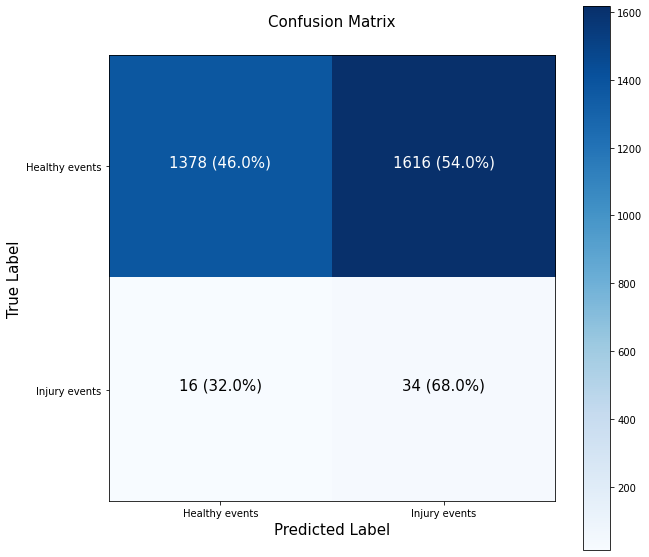

In [142]:
# Evaluate model's performance on the test set, with AUC, confusion matrix, sensitivity and specificity
# You can switch threshold prob in order to bias sensitivity at the cost of specificity. It is set to default 0.5
calib_clf.fit(X_rosus,y_rosus)
y_pred_calib = calib_clf.predict_proba(X_test)
threshold_prob = 0.5
y_pred = []
for y_hat in y_pred_calib:
  if y_hat[1] > threshold_prob:
    y_pred.append(1)
  else:
    y_pred.append(0)

print(f'Area under curve score is {roc_auc_score(y_test,calib_clf.predict_proba(X_test)[:,1])}')

# Compute true positives, true neagatives, false negatives and false positives
tp = confusion_matrix(y_test,np.array(y_pred))[1,1]
tn = confusion_matrix(y_test,np.array(y_pred))[0,0]
fn = confusion_matrix(y_test,np.array(y_pred))[1,0]
fp = confusion_matrix(y_test,np.array(y_pred))[0,1]

# Compute sensitivity and specificity
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
print(f'Sensitivity is {sensitivity*100}% and specificity is {specificity*100}%')

# Plot confusion matrix
plot_confusion_matrix(y_true=y_test, y_pred=np.array(y_pred), class_names=['Healthy events','Injury events'])

## 5) Neural Networks Model

Counter({0: 39189, 1: 533})
Counter({0: 533, 1: 533})
Epoch 1/10
34/34 [==============================] - 2s 5ms/step - loss: 0.6888 - auc: 0.5756
Epoch 2/10
34/34 [==============================] - 0s 4ms/step - loss: 0.6676 - auc: 0.6319
Epoch 3/10
34/34 [==============================] - 0s 4ms/step - loss: 0.6598 - auc: 0.6603
Epoch 4/10
34/34 [==============================] - 0s 5ms/step - loss: 0.6473 - auc: 0.6753
Epoch 5/10
34/34 [==============================] - 0s 4ms/step - loss: 0.6260 - auc: 0.7046
Epoch 6/10
34/34 [==============================] - 0s 4ms/step - loss: 0.6171 - auc: 0.7151
Epoch 7/10
34/34 [==============================] - 0s 5ms/step - loss: 0.5850 - auc: 0.7570
Epoch 8/10
34/34 [==============================] - 0s 4ms/step - loss: 0.5874 - auc: 0.7611
Epoch 9/10
34/34 [==============================] - 0s 5ms/step - loss: 0.5561 - auc: 0.7883
Epoch 10/10
34/34 [==============================] - 0s 4ms/step - loss: 0.5402 - auc: 0.8036
[]
Sensitivity 

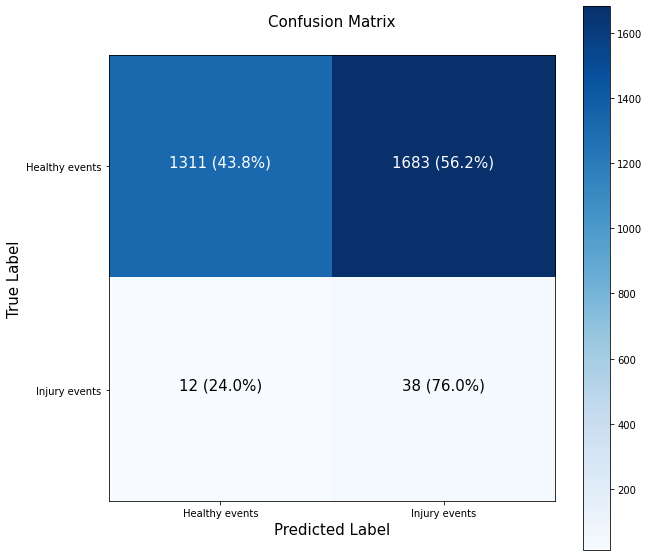

In [148]:
'''Neural Networks Model'''

# Check the number of instances for each class before and after resampling
print(Counter(y_train))
print(Counter(y_rus))

# Scale X data
X_scaled_rus = MinMaxScaler().fit_transform(X_rus)
X_scaled_test = MinMaxScaler().fit_transform(X_test)

# set random seed for reproducibility

tf.random.set_seed(24)

# create model with 9 hidden layers with 50 neurons each and 1 output layer

nn_model = tf.keras.Sequential([tf.keras.layers.Dense(128,activation="relu"),
                                tf.keras.layers.Dropout(0.1),
                                tf.keras.layers.Dense(128,activation="relu"),
                                #tf.keras.layers.Dropout(0.1),
                                tf.keras.layers.Dense(128,activation="relu"),
                                #tf.keras.layers.Dropout(0.1),
                                tf.keras.layers.Dense(128,activation="relu"),
                                #tf.keras.layers.Dropout(0.1),
                                tf.keras.layers.Dense(64,activation="relu"),
                                #tf.keras.layers.Dropout(0.1),
                                tf.keras.layers.Dense(64,activation="relu"),
                                #tf.keras.layers.Dropout(0.1),
                                tf.keras.layers.Dense(64,activation="relu"),
                                #tf.keras.layers.Dropout(0.1),
                                tf.keras.layers.Dense(32,activation="relu"),
                                #tf.keras.layers.Dropout(0.1),
                                tf.keras.layers.Dense(32,activation="relu"),
                                #tf.keras.layers.Dropout(0.1),
                                tf.keras.layers.Dense(1,activation="sigmoid")
])

# compile model

nn_model.compile(loss="binary_crossentropy",
                 optimizer=tf.keras.optimizers.Adam(learning_rate=0.002),
                 metrics=['AUC'])

# set callback to stop after 10 epochs if model doesn't improve and fit training data

callback = tf.keras.callbacks.EarlyStopping(monitor='loss',patience=3)
history = nn_model.fit(X_scaled_rus,y_rus,epochs=10,batch_size=32,callbacks=[callback])

# Evaluate model performance on test set, with AUC, confusion matrix, sensitivity and specificity

y_prob_pred = nn_model.predict(X_scaled_test)
y_pred = []
for i in y_prob_pred:
  if i <=0.5:
    y_pred.append(0)
  else:
    y_pred.append(1)

y_pred = np.array(y_pred)
print(y_pred[y_pred>1])

# Compute true positives, true neagatives, false negatives and false positives
tp = confusion_matrix(y_test,np.array(y_pred))[1,1]
tn = confusion_matrix(y_test,np.array(y_pred))[0,0]
fn = confusion_matrix(y_test,np.array(y_pred))[1,0]
fp = confusion_matrix(y_test,np.array(y_pred))[0,1]

# Compute sensitivity and specificity
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
print(f'Sensitivity is {sensitivity*100}% and specificity is {specificity*100}%')

# Plot confusion matrix
plot_confusion_matrix(y_true=y_test, y_pred=np.array(y_pred), class_names=['Healthy events','Injury events'])

# evaluate the model

print(f'Area Under Curve is {nn_model.evaluate(X_scaled_test,y_test)[1]}')

Epoch 1/30
34/34 [==============================] - 1s 4ms/step - loss: 0.6922 - auc: 0.5587 - lr: 1.0000e-04
Epoch 2/30
34/34 [==============================] - 0s 4ms/step - loss: 0.6902 - auc: 0.6004 - lr: 1.1220e-04
Epoch 3/30
34/34 [==============================] - 0s 4ms/step - loss: 0.6873 - auc: 0.6195 - lr: 1.2589e-04
Epoch 4/30
34/34 [==============================] - 0s 5ms/step - loss: 0.6832 - auc: 0.6329 - lr: 1.4125e-04
Epoch 5/30
34/34 [==============================] - 0s 5ms/step - loss: 0.6775 - auc: 0.6332 - lr: 1.5849e-04
Epoch 6/30
34/34 [==============================] - 0s 5ms/step - loss: 0.6719 - auc: 0.6248 - lr: 1.7783e-04
Epoch 7/30
34/34 [==============================] - 0s 5ms/step - loss: 0.6571 - auc: 0.6605 - lr: 1.9953e-04
Epoch 8/30
34/34 [==============================] - 0s 4ms/step - loss: 0.6502 - auc: 0.6650 - lr: 2.2387e-04
Epoch 9/30
34/34 [==============================] - 0s 5ms/step - loss: 0.6382 - auc: 0.6910 - lr: 2.5119e-04
Epoch 10/3

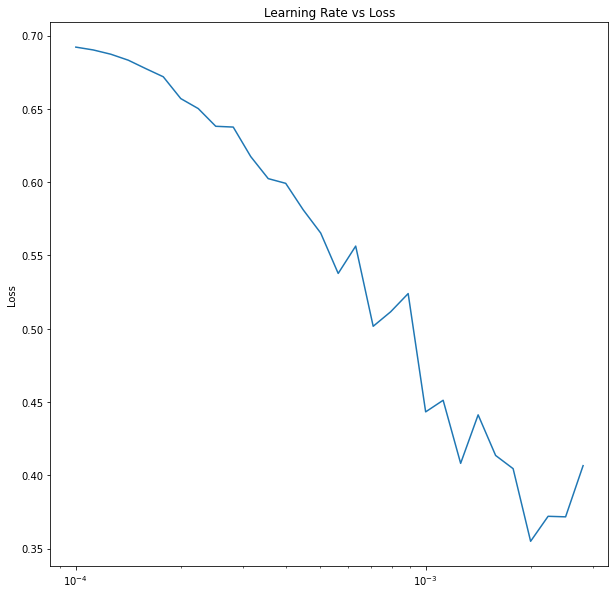

In [149]:
'''Find optimal Learning Rate for nn_model'''

# set random seed for reproducibility

tf.random.set_seed(24)

# create model with 2 hidden layers and 1 output layer

nn_model = tf.keras.Sequential([tf.keras.layers.Dense(128,activation="relu"),
                                tf.keras.layers.Dropout(0.1),
                                tf.keras.layers.Dense(128,activation="relu"),
                                #tf.keras.layers.Dropout(0.1),
                                tf.keras.layers.Dense(128,activation="relu"),
                                #tf.keras.layers.Dropout(0.1),
                                tf.keras.layers.Dense(128,activation="relu"),
                                #tf.keras.layers.Dropout(0.1),
                                tf.keras.layers.Dense(64,activation="relu"),
                                #tf.keras.layers.Dropout(0.1),
                                tf.keras.layers.Dense(64,activation="relu"),
                                #tf.keras.layers.Dropout(0.1),
                                tf.keras.layers.Dense(64,activation="relu"),
                                #tf.keras.layers.Dropout(0.1),
                                tf.keras.layers.Dense(32,activation="relu"),
                                #tf.keras.layers.Dropout(0.1),
                                tf.keras.layers.Dense(32,activation="relu"),
                                #tf.keras.layers.Dropout(0.1),
                                tf.keras.layers.Dense(1,activation="sigmoid")
])

# compile model

nn_model.compile(loss="binary_crossentropy",
                 optimizer=tf.keras.optimizers.Adam(),
                 metrics=["AUC"])

# set callback to stop after 5 epochs if model doesn't improve and fit training data

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10 ** (epoch/20))
history = nn_model.fit(X_scaled_rus,y_rus,epochs=30,callbacks=[lr_scheduler])

# plot accuracy vs learning rate to find optimal learning rate

plt.figure(figsize=[10,10])
plt.semilogx(1e-4 * (10 ** (tf.range(30)/20)),history.history["loss"])
plt.ylabel("Loss")
plt.title("Learning Rate vs Loss")
plt.show()

In [ ]:
'''Crossvalidation on nn_model'''

from keras.wrappers.scikit_learn import KerasClassifier

tf.random.set_seed(24)

def create_nn_model():

  # create model with 2 hidden layers and 1 output layer

  nn_model = tf.keras.Sequential([tf.keras.layers.Dense(128,activation="relu"),
                                tf.keras.layers.Dropout(0.1),
                                tf.keras.layers.Dense(128,activation="relu"),
                                #tf.keras.layers.Dropout(0.1),
                                tf.keras.layers.Dense(128,activation="relu"),
                                #tf.keras.layers.Dropout(0.1),
                                tf.keras.layers.Dense(128,activation="relu"),
                                #tf.keras.layers.Dropout(0.1),
                                tf.keras.layers.Dense(64,activation="relu"),
                                #tf.keras.layers.Dropout(0.1),
                                tf.keras.layers.Dense(64,activation="relu"),
                                #tf.keras.layers.Dropout(0.1),
                                tf.keras.layers.Dense(64,activation="relu"),
                                #tf.keras.layers.Dropout(0.1),
                                tf.keras.layers.Dense(32,activation="relu"),
                                #tf.keras.layers.Dropout(0.1),
                                tf.keras.layers.Dense(32,activation="relu"),
                                #tf.keras.layers.Dropout(0.1),
                                tf.keras.layers.Dense(1,activation="sigmoid")
  ])

  # compile model

  nn_model.compile(loss="binary_crossentropy",
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.002),
                  metrics=["AUC"])
  
  return nn_model


neural_network = KerasClassifier(build_fn=create_nn_model, 
                                 epochs=10)

# Evaluate neural network using 5-fold cross-validation
cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=1)
cross_val_score(neural_network, X_scaled_rus, y_rus, scoring='roc_auc', cv=cv)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.


Epoch 1/10
27/27 [==============================] - 1s 5ms/step - loss: 0.6915 - auc: 0.5386
Epoch 2/10
27/27 [==============================] - 0s 4ms/step - loss: 0.6792 - auc: 0.6074
Epoch 3/10
27/27 [==============================] - 0s 4ms/step - loss: 0.6766 - auc: 0.6373
Epoch 4/10
27/27 [==============================] - 0s 5ms/step - loss: 0.6407 - auc: 0.6840
Epoch 5/10
27/27 [==============================] - 0s 4ms/step - loss: 0.6062 - auc: 0.7312
Epoch 6/10
27/27 [==============================] - 0s 5ms/step - loss: 0.5848 - auc: 0.7632
Epoch 7/10
27/27 [==============================] - 0s 4ms/step - loss: 0.5654 - auc: 0.7733
Epoch 8/10
27/27 [==============================] - 0s 4ms/step - loss: 0.5425 - auc: 0.8030
Epoch 9/10
27/27 [==============================] - 0s 4ms/step - loss: 0.5409 - auc: 0.8013
Epoch 10/10
27/27 [==============================] - 0s 4ms/step - loss: 0.4969 - auc: 0.8382
Epoch 1/10
27/27 [==============================] - 1s 4ms/step - los

array([0.62686698, 0.57970376, 0.6122377 , 0.67025216, 0.62198025])